#Imports


In [1]:
!pip install einops
!pip install git+https://github.com/neelnanda-io/neel-plotly.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
  Cloning https://github.com/neelnanda-io/neel-plotly.git to /tmp/pip-req-build-fnsien00
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/neel-plotly.git /tmp/pip-req-build-fnsien00
  Resolved https://github.com/neelnanda-io/neel-plotly.git to commit 6dc24b26f8dec991908479d7445dae496b3430b7
  Preparing metadata (setup.py) ... done
  Created wheel for neel-plotly: filename=neel_plotly-0.0.0-py3-none-any.whl size=10186 sha256=61a126d0b07e89d171a9867c380d32a781cf6b54e32e94141f4eb67c39ca8c38
  Stored in directory: /tmp/pip-ephem-wheel-cache-1dfkeof3/wheels/32/cf/25/0103b4be02266c40faf008ffa9565a2ba07d1c63118fccc390
Successfully built neel-plotly


In [2]:
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional, Callable
import seaborn as sns


from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange

import time
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import neel_plotly.plot as npx

#Learning rate schedules



In [74]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

In [75]:
DEVICE


'cuda'

In [76]:
def linear_lr(step, steps):
  return (1 - (step / steps))

def constant_lr(*_):
  return 1.0

def cosine_decay_lr(step, steps):
  return np.cos(0.5 * np.pi * step / (steps - 1))


In [77]:
#@title defining loss
import matplotlib.pyplot as plt

def optimize(model,
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             hooks=[]):
    cfg = model.config
    opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

    losses = []

    start = time.time()
    with trange(steps) as t:
        for step in t:
            step_lr = lr * lr_scale(step, steps)
            for group in opt.param_groups:
                group['lr'] = step_lr
            opt.zero_grad(set_to_none=True)
            batch, target = model.generate_batch(n_batch)
            hidden, out = model(batch)
            error = (model.importance*(target - out)**2)
            h1_l1 = torch.abs(hidden.mean((0, 1)).sum())
            loss = einops.reduce(error, 'b i f -> i', 'mean').sum() + cfg.hidden_l1*h1_l1
            loss.backward()
            opt.step()

            losses.append(loss.item() / cfg.n_instances)

            if hooks:
                hook_data = dict(model=model,
                                step=step,
                                opt=opt,
                                error=error,
                                loss=loss,
                                lr=step_lr)
                for h in hooks:
                    h(hook_data)
            if step % print_freq == 0 or (step + 1 == steps):
                t.set_postfix(
                    loss=loss.item() / cfg.n_instances,
                    lr=step_lr,
                )

    return losses

def compare_models(model1, model2, **kwargs):
    losses1 = optimize(model1, **kwargs)
    losses2 = optimize(model2, **kwargs)

    plt.plot(losses1, label='Model 1')
    plt.plot(losses2, label='Model 2')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Loss vs Steps')
    plt.legend()
    plt.show()


#Visualization functions


In [10]:
def visualize_weights(model):
    W1 = model.W1.detach().cpu()
    W2 = model.W2.detach().cpu()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(W1.numpy().reshape(model.config.n_instances, -1), ax=ax1, cmap="coolwarm", center=0)
    ax1.set_title("W1")

    sns.heatmap(W2.numpy().reshape(model.config.n_instances, -1), ax=ax2, cmap="coolwarm", center=0)
    ax2.set_title("W2")

    plt.show()

In [11]:
def visualize_w_net(model):
    W1 = model.W1.detach().cpu()
    W2 = model.W2.detach().cpu()

    # Initialize an empty tensor to store the results
    W_net = torch.zeros(W1.shape[0], W1.shape[1], W2.shape[2])

    # Perform the matrix multiplication for each instance
    for i in range(W1.shape[0]):
        W_net[i] = torch.matmul(W1[i], W2[i])

    fig, ax = plt.subplots(figsize=(8, 6))

    sns.heatmap(W_net.numpy().reshape(model.config.n_instances, -1), ax=ax, cmap="coolwarm", center=0)
    ax.set_title("W_net")

    plt.show()


In [35]:
def visualize_weights_stacked(model):
    W_net = torch.matmul(model.W1.detach().cpu(), model.W2.detach().cpu())  # compute W_net
    W_net = W_net.numpy().reshape(model.config.n_instances, -1)  # reshape to 2D array
    n_neurons = W_net.shape[1]

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # For each neuron, create a stacked bar plot
    for i in range(n_neurons):
        weights = W_net[:, i]
        positive_weights = np.maximum(weights, 0)
        negative_weights = np.minimum(weights, 0)

        # Create stacked bar for positive weights
        ax.bar(i, positive_weights, color=plt.cm.viridis(np.linspace(0, 1, len(positive_weights))))

        # Create stacked bar for negative weights
        ax.bar(i, negative_weights, color=plt.cm.viridis(np.linspace(0, 1, len(negative_weights))))

    # Set labels and title
    ax.set_xlabel('Neurons')
    ax.set_ylabel('Weights')
    ax.set_title('Per-neuron stacked bar plot of weights')
    plt.show()



#Target functions

##z = x AND y

###Define model

In [72]:
#@title Model

@dataclass
class Config:
  n_features: int
  n_hidden: int

  # We could potentially use torch.vmap instead.
  n_instances: int

  #New configurable parameters
  dropout: float = 0
  activation: Callable = F.relu
  hidden_l1: int = 0

class Model(nn.Module):
    def __init__(self,
                 config,
                 feature_probability: Optional[torch.Tensor] = None,
                 importance: Optional[torch.Tensor] = None,
                 device='cuda'):
        super().__init__()
        self.config = config
        self.W1 = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
        self.W2 = nn.Parameter(torch.empty((config.n_instances, config.n_hidden, config.n_features), device=device))
        nn.init.xavier_normal_(self.W1)
        nn.init.xavier_normal_(self.W2)
        self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))

        if feature_probability is None:
          feature_probability = torch.ones(())
        self.feature_probability = feature_probability.to(device)
        if importance is None:
          importance = torch.ones(())
        self.importance = importance.to(device)

    def forward(self, features):
        # features: [..., instance, n_features]
        # W1: [instance, n_features, n_hidden]
        hidden = torch.einsum("...if,ifh->...ih", features, self.W1)
        hidden = self.config.activation(hidden)  # Apply activation function to the hidden layer

        if self.config.dropout!=0:
            hidden = torch.nn.functional.dropout(hidden, p=self.config.dropout)
        # W2: [instance, n_hidden, n_features]
        out = torch.einsum("...ih,ihf->...if", hidden, self.W2)
        out = out + self.b_final
        out = self.config.activation(out)
        return hidden, out

    def generate_batch(self, n_batch):
        feat = torch.randint(2, (n_batch, self.config.n_instances, self.config.n_features), device=self.W1.device)
        batch = torch.where(
            torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W1.device) <= self.feature_probability,
            feat,
            torch.zeros((), device=self.W1.device),
        )
        target = (batch[..., 0] * batch[..., 1]).unsqueeze(-1)
        return batch, target


###Train models and visualize loss curves

Optimizing model ReLU


  0%|          | 0/10000 [00:00<?, ?it/s]

Optimizing model GeLU


  0%|          | 0/10000 [00:00<?, ?it/s]

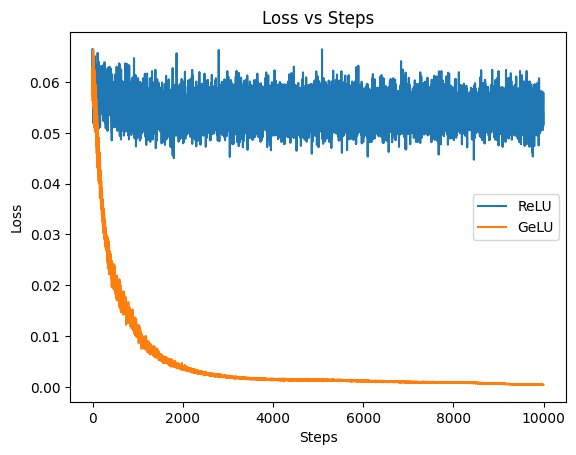

In [78]:
# Instantiate two models
configs = {
    "ReLU": Config(
        n_features=2,
        n_hidden=2,
        n_instances=5,
    ),
    "GeLU": Config(
        n_features=2,
        n_hidden=2,
        n_instances=5,
        activation=F.gelu,
    )
}

models = {}
for name, config in configs.items():
    models[name] = Model(
        config=config,
        device=DEVICE,
        importance=(0.9 ** torch.arange(config.n_features))[None, :],
        feature_probability=(20 ** -torch.linspace(0, 1, config.n_instances))[:, None]
    )

# Optimize the models and store the loss histories
loss_histories = {}
for name, model in models.items():
    print(f"Optimizing model {name}")
    loss_histories[name] = optimize(model, n_batch=1024, steps=10_000, print_freq=100, lr=1e-3, lr_scale=constant_lr)
# Plot loss curves on the same graph
for name, losses in loss_histories.items():
    plt.plot(losses, label=name)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss vs Steps')
plt.legend()
plt.show()

###Visualize weights

Visualizing weights for model ReLU


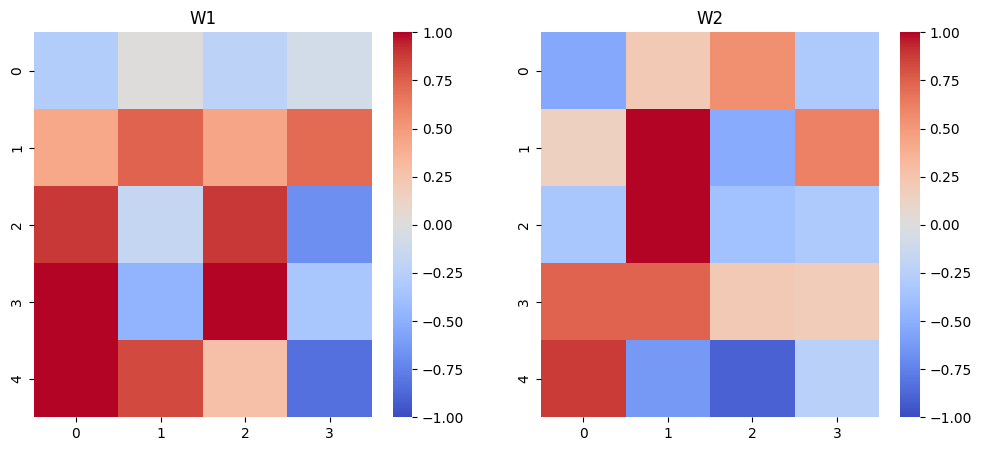

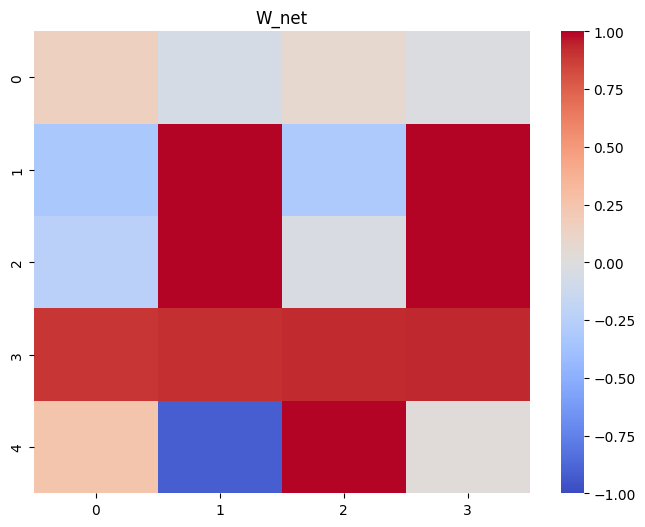

Visualizing weights for model GeLU


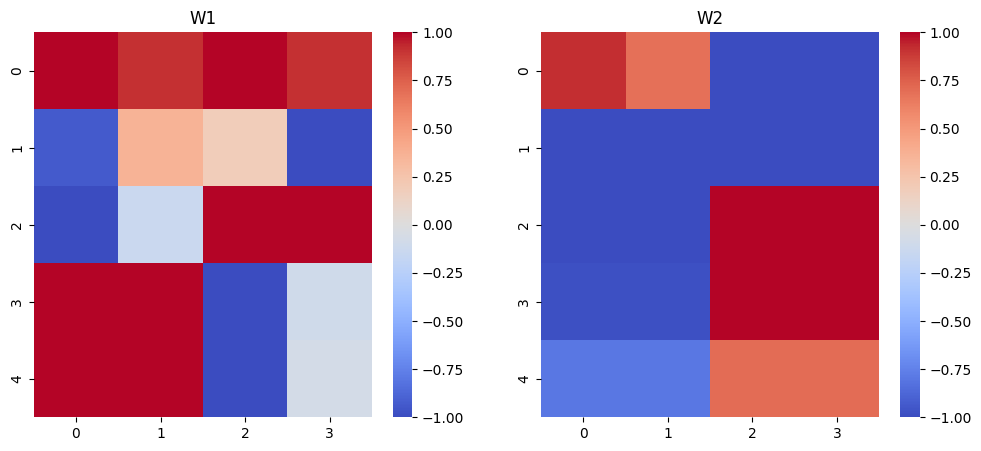

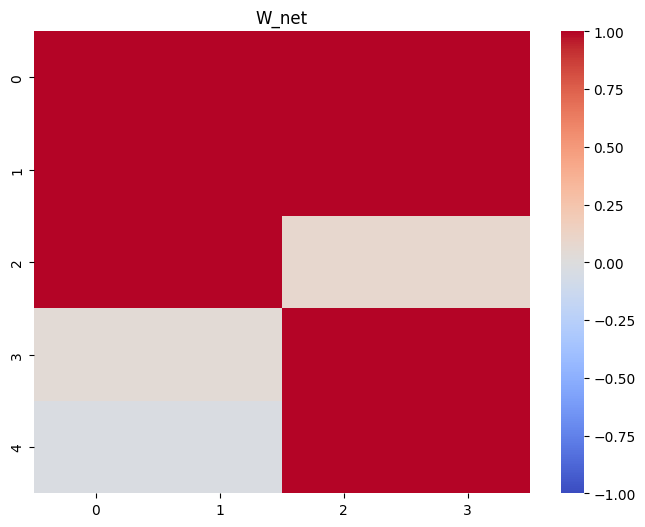

Visualizing weights for model ReLU


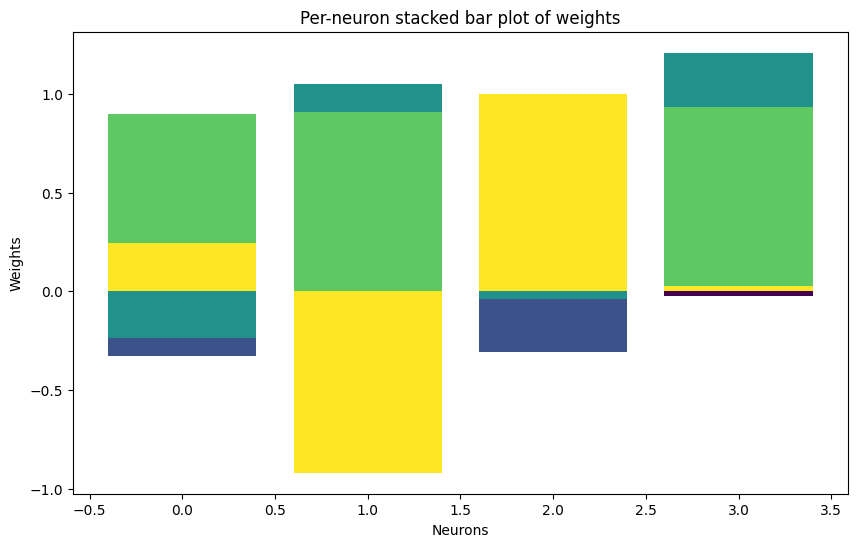

Visualizing weights for model GeLU


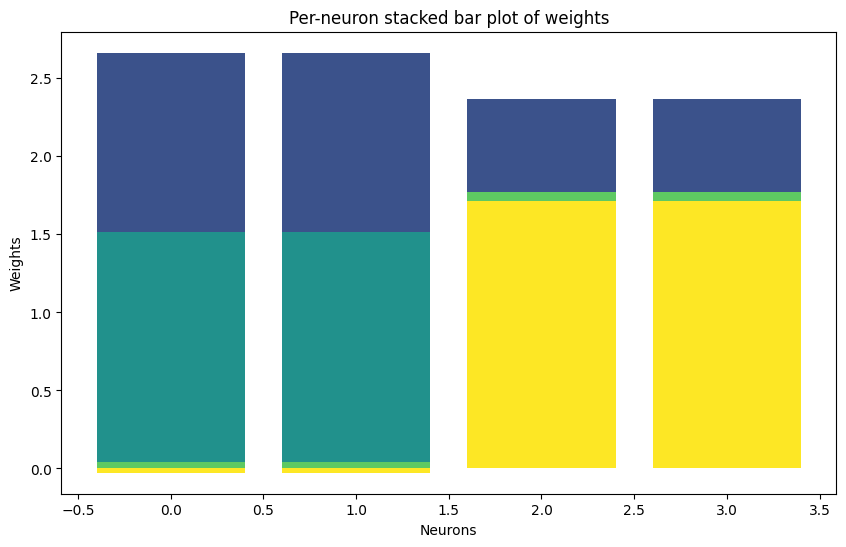

In [79]:
# Visualize W1, W2, and W_net for both models
for name, model in models.items():
    print(f"Visualizing weights for model {name}")
    visualize_weights(model)
    visualize_w_net(model)

# Visualize W_net for both models
for name, model in models.items():
    print(f"Visualizing weights for model {name}")
    visualize_weights_stacked(model)


##Logical OR

###Model definition

In [80]:
#@title Model

@dataclass
class Config:
  n_features: int
  n_hidden: int

  # We could potentially use torch.vmap instead.
  n_instances: int

  #New configurable parameters
  dropout: float = 0
  activation: Callable = F.relu
  hidden_l1: int = 0

class Model(nn.Module):
    def __init__(self,
                 config,
                 feature_probability: Optional[torch.Tensor] = None,
                 importance: Optional[torch.Tensor] = None,
                 device='cuda'):
        super().__init__()
        self.config = config
        self.W1 = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
        self.W2 = nn.Parameter(torch.empty((config.n_instances, config.n_hidden, config.n_features), device=device))
        nn.init.xavier_normal_(self.W1)
        nn.init.xavier_normal_(self.W2)
        self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))

        if feature_probability is None:
          feature_probability = torch.ones(())
        self.feature_probability = feature_probability.to(device)
        if importance is None:
          importance = torch.ones(())
        self.importance = importance.to(device)

    def forward(self, features):
        # features: [..., instance, n_features]
        # W1: [instance, n_features, n_hidden]
        hidden = torch.einsum("...if,ifh->...ih", features, self.W1)
        hidden = self.config.activation(hidden)  # Apply activation function to the hidden layer

        if self.config.dropout!=0:
            hidden = torch.nn.functional.dropout(hidden, p=self.config.dropout)
        # W2: [instance, n_hidden, n_features]
        out = torch.einsum("...ih,ihf->...if", hidden, self.W2)
        out = out + self.b_final
        out = self.config.activation(out)
        return hidden, out

    def generate_batch(self, n_batch):
        feat = torch.randint(2, (n_batch, self.config.n_instances, self.config.n_features), device=self.W1.device)
        batch = torch.where(
            torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W1.device) <= self.feature_probability,
            feat,
            torch.zeros((), device=self.W1.device),
        )
        target = torch.max(batch[..., 0], batch[..., 1]).unsqueeze(-1)

        return batch, target


###Instantiate and train models

In [40]:
# Instantiate two models
configs = {
    "ReLU": Config(
        n_features=2,
        n_hidden=2,
        n_instances=5,
    ),
    "GeLU": Config(
        n_features=2,
        n_hidden=2,
        n_instances=5,
        activation=F.gelu,
    )
}

models = {}
for name, config in configs.items():
    models[name] = Model(
        config=config,
        device=DEVICE,
        importance=(0.9 ** torch.arange(config.n_features))[None, :],
        feature_probability=(20 ** -torch.linspace(0, 1, config.n_instances))[:, None]
    )
# Optimize the models and store the loss histories
loss_histories = {}
for name, model in models.items():
    print(f"Optimizing model {name}")
    loss_histories[name] = optimize(model, n_batch=1024, steps=10_000, print_freq=100, lr=1e-3, lr_scale=constant_lr)


Optimizing model ReLU


  0%|          | 0/10000 [00:00<?, ?it/s]

Optimizing model GeLU


  0%|          | 0/10000 [00:00<?, ?it/s]

###Visualize loss curves

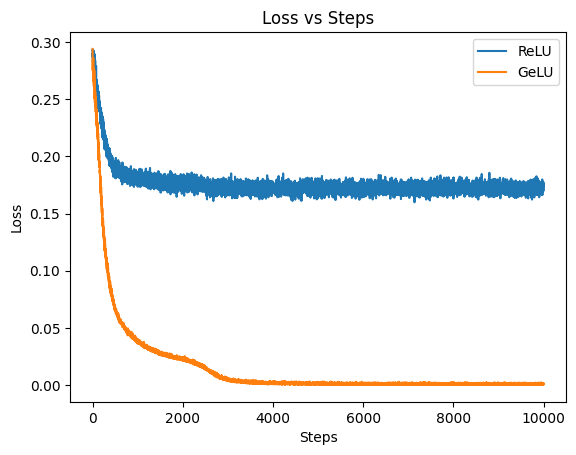

In [41]:
# Plot loss curves on the same graph
for name, losses in loss_histories.items():
    plt.plot(losses, label=name)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss vs Steps')
plt.legend()
plt.show()

###Visualize weights

Visualizing weights for model ReLU


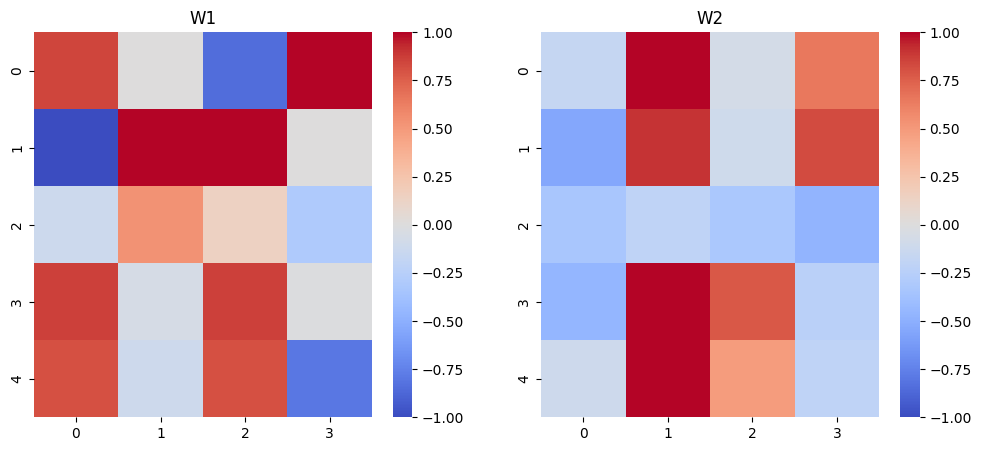

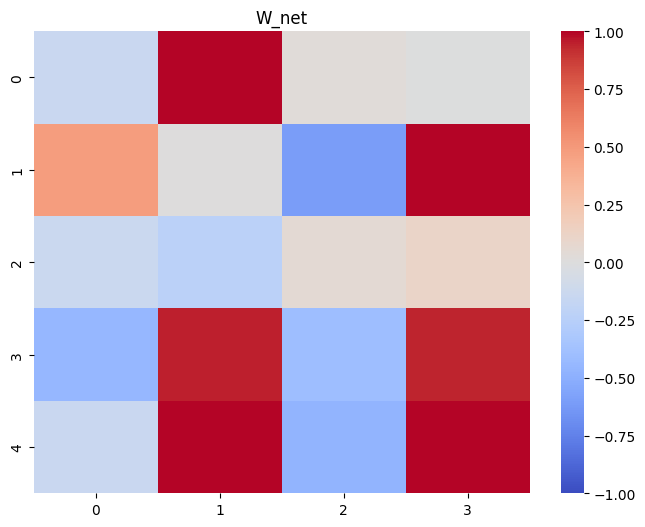

Visualizing weights for model GeLU


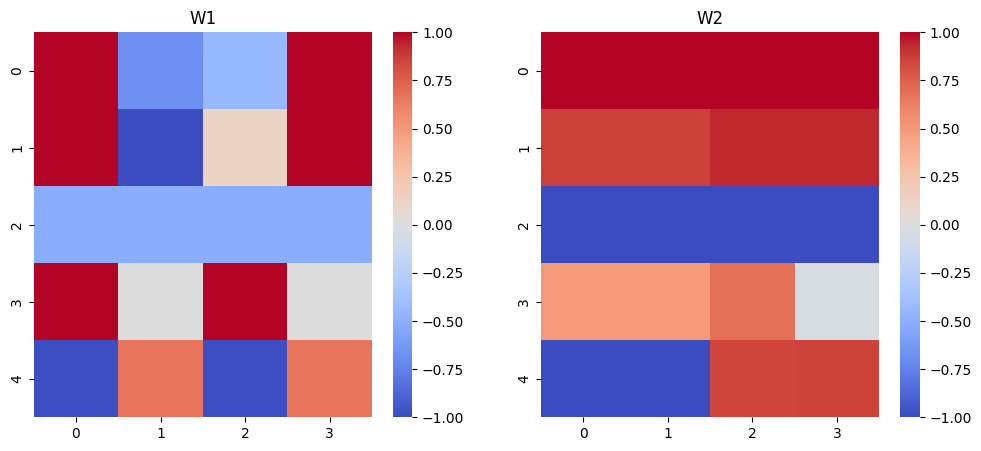

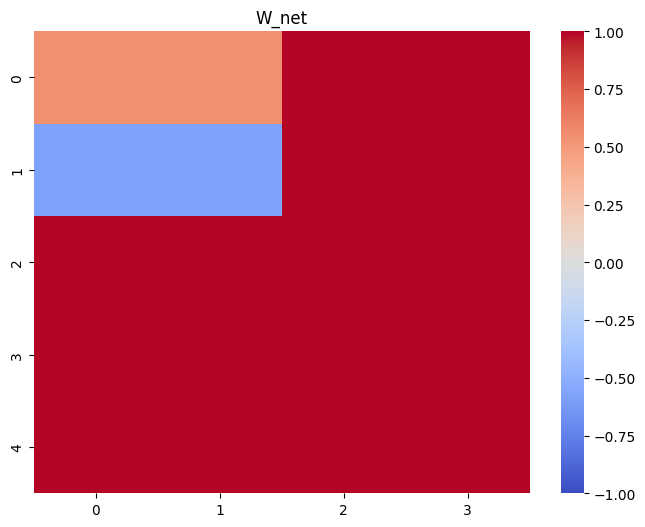

Visualizing weights for model ReLU


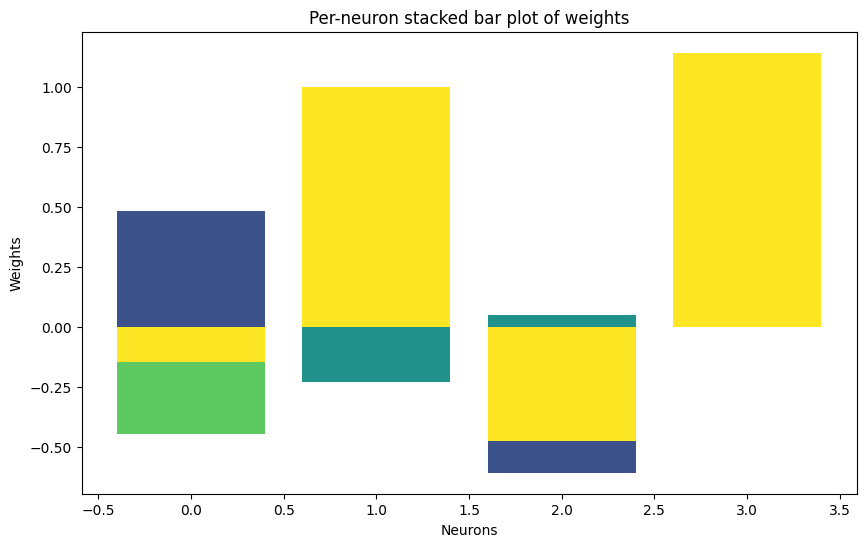

Visualizing weights for model GeLU


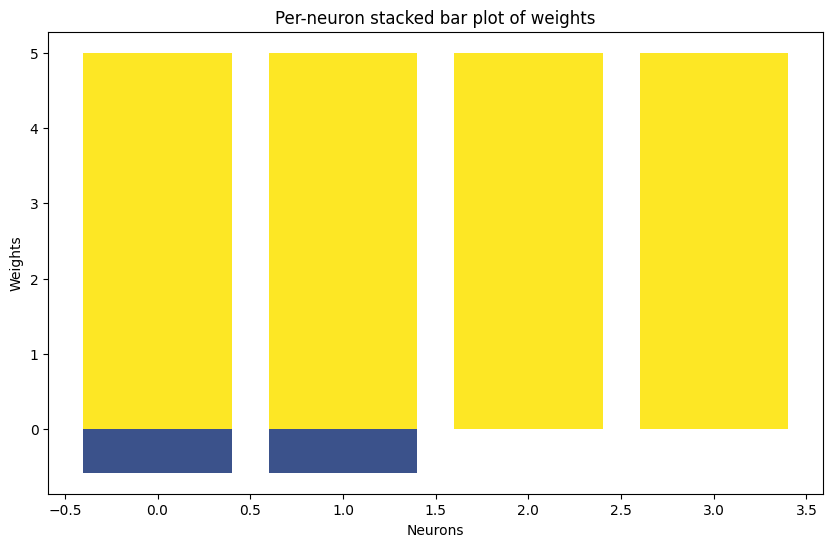

In [42]:
# Visualize W1, W2, and W_net for both models
for name, model in models.items():
    print(f"Visualizing weights for model {name}")
    visualize_weights(model)
    visualize_w_net(model)

# Visualize W_net for both models
for name, model in models.items():
    print(f"Visualizing weights for model {name}")
    visualize_weights_stacked(model)


##max(|x|,|y|)

###Define model

In [25]:
#@title Model

@dataclass
class Config:
  n_features: int
  n_hidden: int

  # We could potentially use torch.vmap instead.
  n_instances: int

  #New configurable parameters
  dropout: float = 0
  activation: Callable = F.relu
  hidden_l1: int = 0

class Model(nn.Module):
    def __init__(self,
                 config,
                 feature_probability: Optional[torch.Tensor] = None,
                 importance: Optional[torch.Tensor] = None,
                 device='cuda'):
        super().__init__()
        self.config = config
        self.W1 = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
        self.W2 = nn.Parameter(torch.empty((config.n_instances, config.n_hidden, config.n_features), device=device))
        nn.init.xavier_normal_(self.W1)
        nn.init.xavier_normal_(self.W2)
        self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))

        if feature_probability is None:
          feature_probability = torch.ones(())
        self.feature_probability = feature_probability.to(device)
        if importance is None:
          importance = torch.ones(())
        self.importance = importance.to(device)

    def forward(self, features):
        # features: [..., instance, n_features]
        # W1: [instance, n_features, n_hidden]
        hidden = torch.einsum("...if,ifh->...ih", features, self.W1)
        hidden = self.config.activation(hidden)  # Apply activation function to the hidden layer

        if self.config.dropout!=0:
            hidden = torch.nn.functional.dropout(hidden, p=self.config.dropout)
        # W2: [instance, n_hidden, n_features]
        out = torch.einsum("...ih,ihf->...if", hidden, self.W2)
        out = out + self.b_final
        out = self.config.activation(out)
        return hidden, out

    def generate_batch(self, n_batch):
        feat = torch.randint(-1, 2, (n_batch, self.config.n_instances, self.config.n_features), device=self.W1.device)

        batch = torch.where(
            torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W1.device) <= self.feature_probability,
            feat,
            torch.zeros((), device=self.W1.device),
        )
        target = torch.max(torch.abs(batch[..., 0]), torch.abs(batch[..., 1])).unsqueeze(-1)


        return batch, target


###train

In [26]:
# Instantiate two models
configs = {
    "ReLU": Config(
        n_features=2,
        n_hidden=2,
        n_instances=5,
    ),
    "GeLU": Config(
        n_features=2,
        n_hidden=2,
        n_instances=5,
        activation=F.gelu,
    )
}

models = {}
for name, config in configs.items():
    models[name] = Model(
        config=config,
        device=DEVICE,
        importance=(0.9 ** torch.arange(config.n_features))[None, :],
        feature_probability=(20 ** -torch.linspace(0, 1, config.n_instances))[:, None]
    )
# Optimize the models and store the loss histories
loss_histories = {}
for name, model in models.items():
    print(f"Optimizing model {name}")
    loss_histories[name] = optimize(model, n_batch=1024, steps=10_000, print_freq=100, lr=1e-3, lr_scale=constant_lr)


Optimizing model ReLU


  0%|          | 0/10000 [00:00<?, ?it/s]

Optimizing model GeLU


  0%|          | 0/10000 [00:00<?, ?it/s]

###Visualize loss and weights

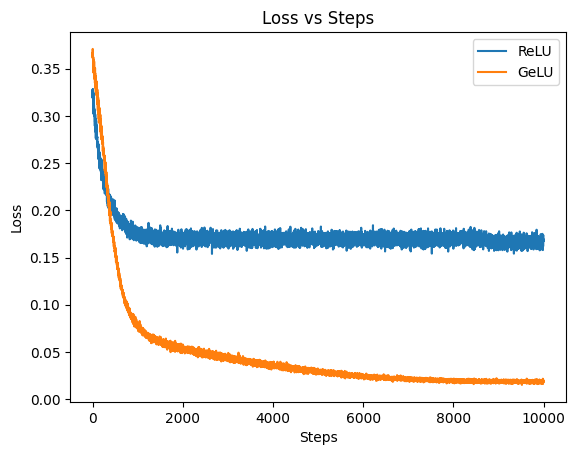

Visualizing weights for model ReLU


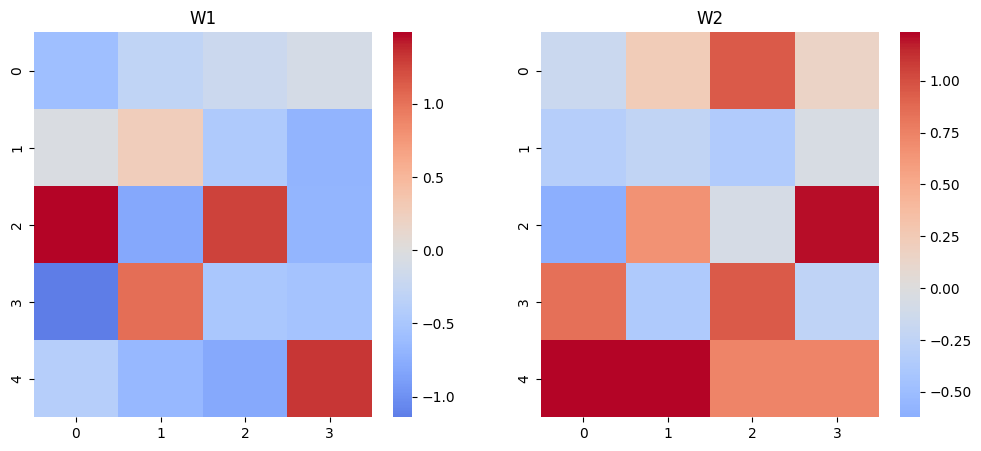

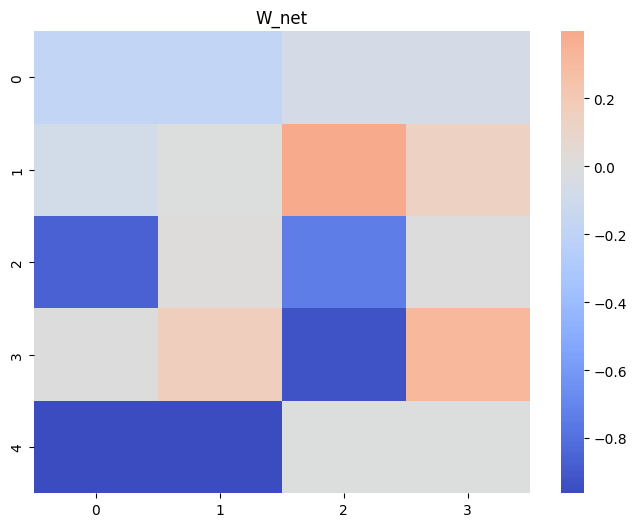

Visualizing weights for model GeLU


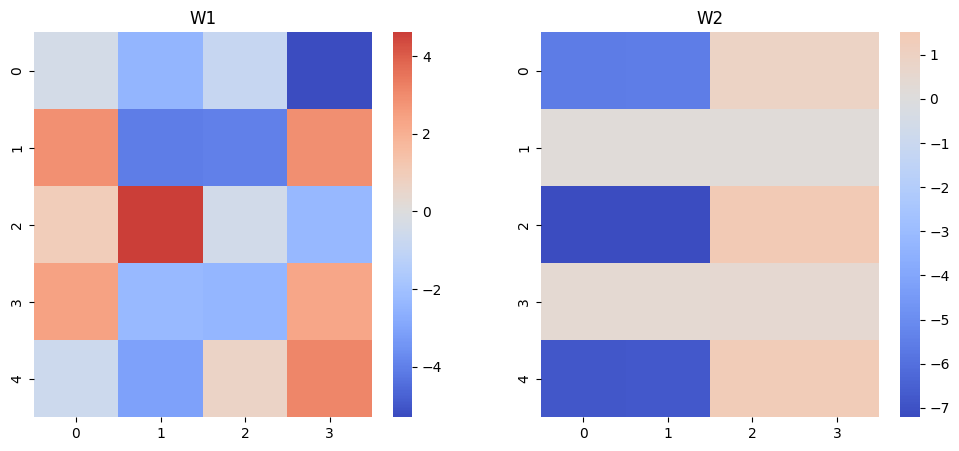

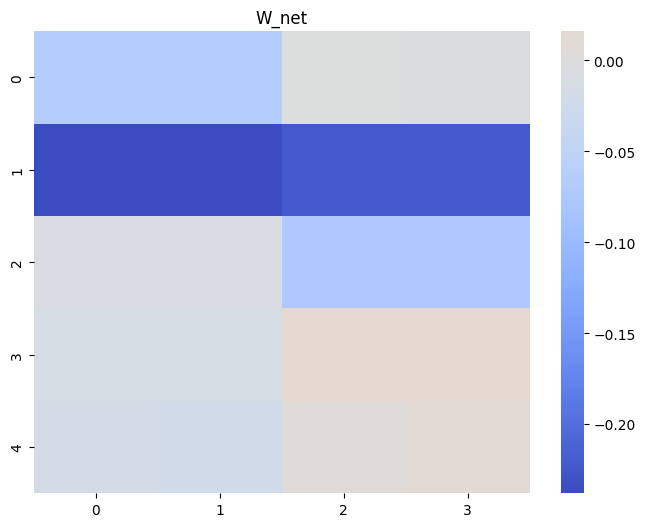

In [27]:
# Plot loss curves on the same graph
for name, losses in loss_histories.items():
    plt.plot(losses, label=name)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss vs Steps')
plt.legend()
plt.show()
# Visualize W1, W2, and W_net for both models
for name, model in models.items():
    print(f"Visualizing weights for model {name}")
    visualize_weights(model)
    visualize_w_net(model)

## y = abs(x)

###Define training

In [81]:
def generate_batch(self, n_batch):
    feat = torch.randint(-1, 2, (n_batch, self.config.n_instances, self.config.n_features), device=self.W1.device)

    batch = torch.where(
        torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W1.device) <= self.feature_probability,
        feat,
        torch.zeros((), device=self.W1.device),
    )
    target = torch.abs(batch[..., 0]).unsqueeze(-1)  # Change here: calculate absolute value for single feature

    return batch, target


###train models

Optimizing model ReLU


  0%|          | 0/10000 [00:00<?, ?it/s]

Optimizing model GeLU


  0%|          | 0/10000 [00:00<?, ?it/s]

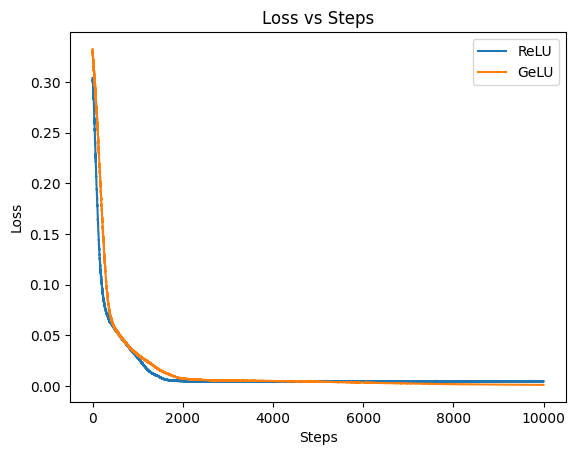

In [82]:
# Instantiate the models with new parameters
configs = {
    "ReLU": Config(
        n_features=3,
        n_hidden=6,
        n_instances=5,
    ),
    "GeLU": Config(
        n_features=3,
        n_hidden=6,
        n_instances=5,
        activation=F.gelu,
    )
}

models = {}
for name, config in configs.items():
    models[name] = Model(
        config=config,
        device=DEVICE,
        importance=torch.ones(config.n_features),
    )

# Update the generate_batch method
def generate_batch(self, n_batch):
    feat = torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W1.device) * 2 - 1
    target = torch.abs(feat)
    return feat, target

Model.generate_batch = generate_batch  # Update the method in the Model class

# Optimize the models and store the loss histories
loss_histories = {}
for name, model in models.items():
    print(f"Optimizing model {name}")
    loss_histories[name] = optimize(model, n_batch=1024, steps=10_000, print_freq=100, lr=1e-3, lr_scale=constant_lr)

# Plot loss curves on the same graph
for name, losses in loss_histories.items():
    plt.plot(losses, label=name)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss vs Steps')
plt.legend()
plt.show()


###Visualize weights

Visualizing weights for model ReLU


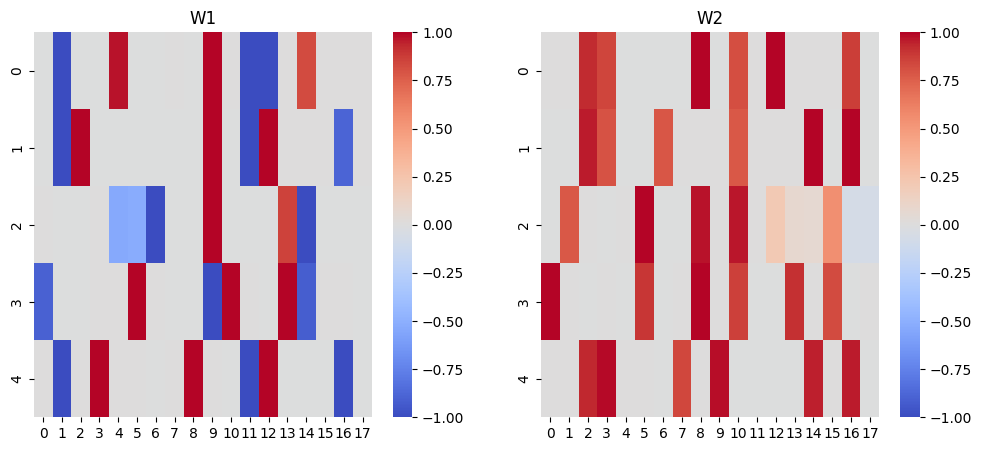

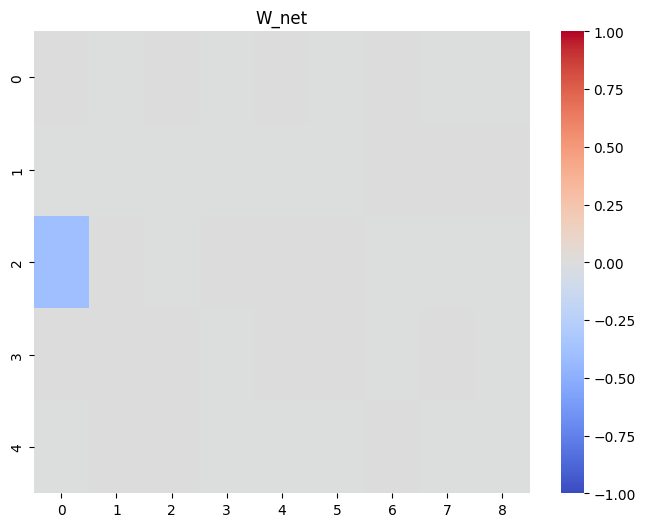

Visualizing weights for model GeLU


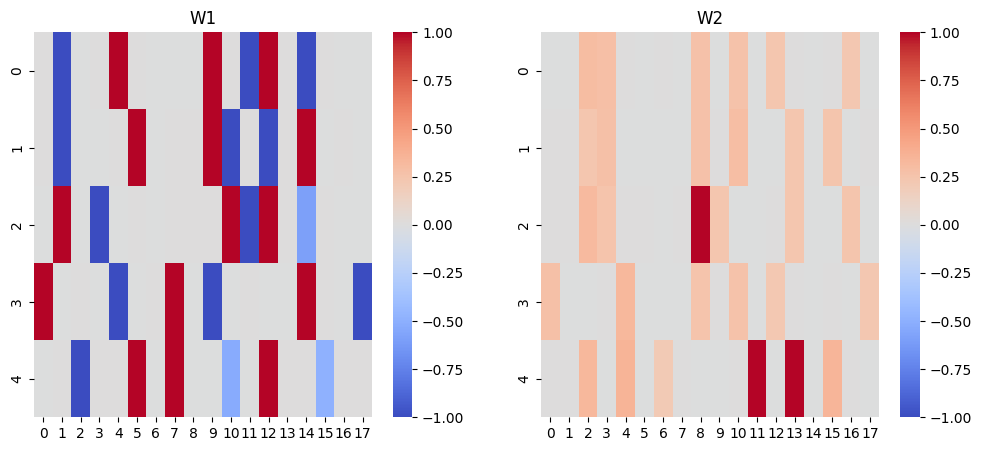

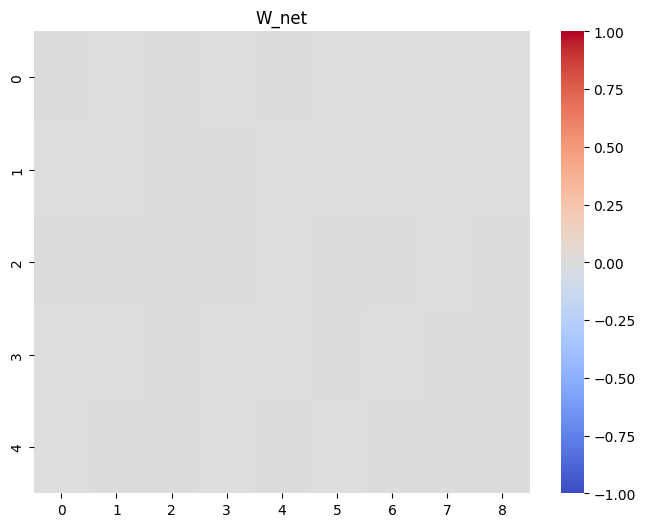

In [83]:
# Visualize W1, W2, and W_net for both models
for name, model in models.items():
    print(f"Visualizing weights for model {name}")
    visualize_weights(model)
    visualize_w_net(model)

Visualizing weights for model ReLU


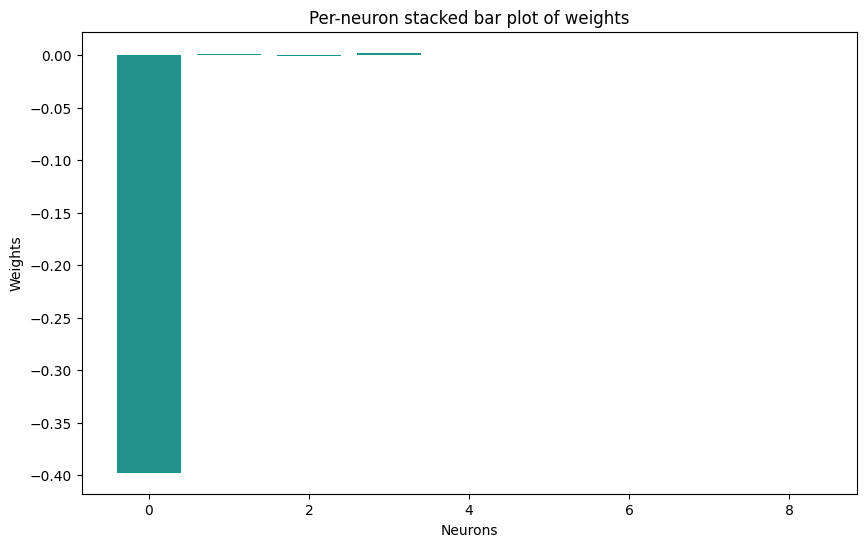

Visualizing weights for model GeLU


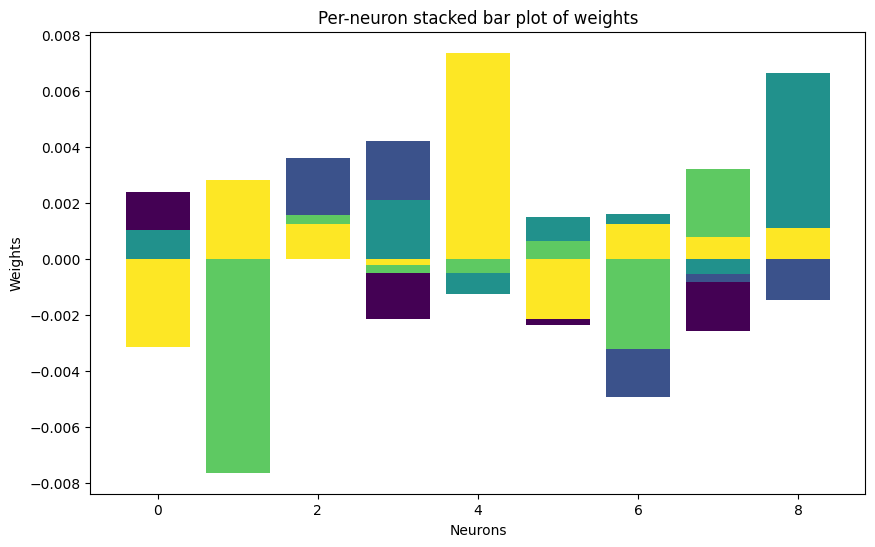

In [84]:
# Visualize W_net for both models
for name, model in models.items():
    print(f"Visualizing weights for model {name}")
    visualize_weights_stacked(model)
